## Metapopulation SEIR model with cross-coupling and/or migration
    
*Author*: Constanze Ciavarella @ConniCia

*Date*: 2018-10-02

## Requirements
To use odin, we need to install the package along with its dependencies. This is done using the following commands:

In [1]:
if (!require("drat")) install.packages("drat")
drat:::add("mrc-ide")
install.packages("dde")
install.packages("odin")

Loading required package: drat
Installing package into ‘/home/simon/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Installing package into ‘/home/simon/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)


We also define the following helper functions:

In [2]:
# beta matrix: random initialisation -----------------------------------------------------
beta.mat <- function (nr_patches) {
  ## beta: positive, non-symmetric matrix of effective contact rates
  ## values are higher on the diagonal (transmission is higher *within*-patch),
  ## values decrease gradually further away from the diagonal (*between*-patch transmission)
  beta <- matrix(0, nrow=nr_patches, ncol=nr_patches)
  for (i in 0:(nr_patches-1)) {
    ## superdiagonal: scale vector s.t. numbers decrease further away from diagonal
    rand.vec <- rnorm(nr_patches-i, 10 * (nr_patches-i)/nr_patches, 2)
    beta[row(beta) == col(beta) - i] <- rand.vec
    ## subdiagonal
    rand.vec <- rnorm(nr_patches-i, 10 * (nr_patches-i)/nr_patches, 2)
    beta[row(beta) == col(beta) - i] <- rand.vec
  }
  return(beta)
}

# mobility matrix: random initialisation -----------------------------------------------------
mob.mat <- function (nr_patches) {
  ## mobility matrix (origin-destination matrix of proportion of population that travels) #TODO trip counts or relative?
  C <- matrix(0, nrow=nr_patches, ncol=nr_patches)
  if (nr_patches > 1) {
    diag(C) <- -sample(1:25, nr_patches, replace=TRUE)
    for (i in 1:nr_patches) {
      C[i, which(C[i, ] == 0)] <- rmultinom(n = 1, size = -C[i,i], prob = rep(1, nr_patches-1))
    }
    C <- C/100
  }
  return(C)
}

# plotting --------------------------------------------------------------------#
plot.pretty <- function(out, nr_patches, what) {
  
  # plot total densities by disease status --------------------------------------#
  if (what == "total") {
    ## compute total densities by disease status
    S_tot <- rowSums(out$S) / nr_patches
    E_tot <- rowSums(out$E) / nr_patches
    I_tot <- rowSums(out$I) / nr_patches
    R_tot <- rowSums(out$R) / nr_patches
    
    ## plot total densities by disease status
    par(mfrow=c(1, 1), las=1, omi=c(1,0,0,0), xpd=NA)
    plot( t, S_tot, col="green",
          type="l", xlab="Days", ylab="Densities",
          main="Total densities by disease status")
    lines(t, E_tot, col="orange")
    lines(t, I_tot, col="red")
    lines(t, R_tot, col="blue")
    legend(-8.5, -0.3, title="Disease statuses", horiz=TRUE,
           legend=c("Susceptible", "Exposed", "Infectious", "Recovered"),
           col=c("green", "orange", "red", "blue"), lty=1)
  }
  
  # plot densities of some patches by disease status ----------------------------#
  if (what == "panels") {
    ## define the plot panels
    if (nr_patches >= 6) {
      mfrow=c(2, 3)
      panels <- as.integer( seq(1, nr_patches, length.out=6))
    } else if (nr_patches >= 4) {
      mfrow=c(2, 2)
      panels <- as.integer( seq(1, nr_patches, length.out=4))
    } else {
      mfrow=c(1, nr_patches)
      panels <- 1:nr_patches
    }
    par(mfrow=mfrow, las=1, omi=c(1,0,0.3,0), xpd=NA)
    
    ## plot the disease statuses of some patches
    ymax <- max(out$N[, panels])
    for (i in panels) {
      plot (t, out$S[, i], col="green", ylim=c(0, ymax),
            type="l", xlab="Days", ylab="Densities",
            main=paste("Patch ", i))
      lines(t, out$E[, i], col="orange")
      lines(t, out$I[, i], col="red")
      lines(t, out$R[, i], col="blue")
    }
    title("Densities by disease status", outer=TRUE)
    legend(-130, -1.2, title="Disease statuses", horiz=TRUE,
           legend=c("Susceptible", "Exposed", "Infectious", "Recovered"),
           col=c("green", "orange", "red", "blue"), lty=1)
  }
  
}

The model is specified in odin as:

In [3]:
SEIR_cont <- odin::odin({
  nr_patches <- user()
  n <- nr_patches
  
  ## Params
  lambda_prod[ , ] <- beta[i, j] * I[j]
  lambda[] <- sum(lambda_prod[i, ]) # rowSums
  
  mob_prod[ , ] <- S[i] * C[i, j]
  mob_S[] <- sum(mob_prod[, i])     # colSums
  mob_prod[ , ] <- E[i] * C[i, j]
  mob_E[] <- sum(mob_prod[, i])
  mob_prod[ , ] <- I[i] * C[i, j]
  mob_I[] <- sum(mob_prod[, i])
  mob_prod[ , ] <- R[i] * C[i, j]
  mob_R[] <- sum(mob_prod[, i])
  
  N[] <- S[i] + E[i] + I[i] + R[i]
  output(N[]) <- TRUE
  
  ## Derivatives
  deriv(S[]) <- mu - mu*S[i] - S[i]*lambda[i]         + M[1] * mob_S[i]
  deriv(E[]) <- S[i]*lambda[i] - (mu + sigma) * E[i]  + M[2] * mob_E[i]
  deriv(I[]) <- sigma*E[i] - (mu + gamma)*I[i]        + M[3] * mob_I[i]
  deriv(R[]) <- gamma*I[i] - mu*R[i]                  + M[4] * mob_R[i]
  
  ## Initial conditions
  initial(S[]) <- 1.0 - 1E-6
  initial(E[]) <- 0.0
  initial(I[]) <- 1E-6
  initial(R[]) <- 0.0
  
  ## parameters
  beta[,] <- user()   # effective contact rate
  sigma   <- 1/3      # rate of breakdown to active disease
  gamma   <- 1/3      # rate of recovery from active disease
  mu      <- 1/10     # background mortality
  C[,]    <- user()   # origin-destination matrix of proportion of population that travels
  M[]     <- user()   # relative migration propensity by disease status
  
  ## dimensions
  dim(beta)        <- c(n, n)
  dim(C)           <- c(n, n)
  dim(M)           <- 4
  dim(lambda_prod) <- c(n, n)
  dim(lambda)      <- n
  dim(mob_prod)    <- c(n, n)
  dim(mob_S)       <- n
  dim(mob_E)       <- n
  dim(mob_I)       <- n
  dim(mob_R)       <- n
  dim(S)           <- n
  dim(E)           <- n
  dim(I)           <- n
  dim(R)           <- n
  dim(N)           <- n
  
})

Compiling shared library


gcc -I/usr/local/lib/R/include -DNDEBUG   -I/usr/local/include   -fpic  -g -O2  -c odin.c -o odin.o
g++ -shared -L/usr/local/lib/R/lib -L/usr/local/lib -o odin_b0e443ee.so odin.o -L/usr/local/lib/R/lib -lR


## Running the model

We first define the user-specified parameters. The default values provided below all satisfy model requirements, but can be changed if needed.

In [4]:
# set seed
set.seed(1)

# SEIR free parameters --------------------------------------------------------#
## total number of patches in the model
nr_patches = 20
## relative migration propensity by disease status (S, E, I, R)
M <- c(1, 0.5, 1, 1)
## matrix of effective contact rates
beta <- beta.mat(nr_patches)
## mobility matrix
C <- mob.mat(nr_patches)

Now we run the model. Note that each patch is initialised with the same population size. We also run a test to make sure that the total population size has remained constant throughout the simulation.

In [5]:
# run SEIR model --------------------------------------------------------------#
mod <- SEIR_cont(nr_patches=nr_patches, beta=beta, C=C, M=M)
t <- seq(0, 50, length.out=50000)
out <- mod$run(t)
out <- mod$transform_variables(out)
# error check -----------------------------------------------------------------#
if ( ! all( abs(rowSums(out$N) - nr_patches) < 1E-10 ) )
  warning("Something went wrong, density is increasing/decreasing!\n")

Now we can plot the disease dynamics in the total population.

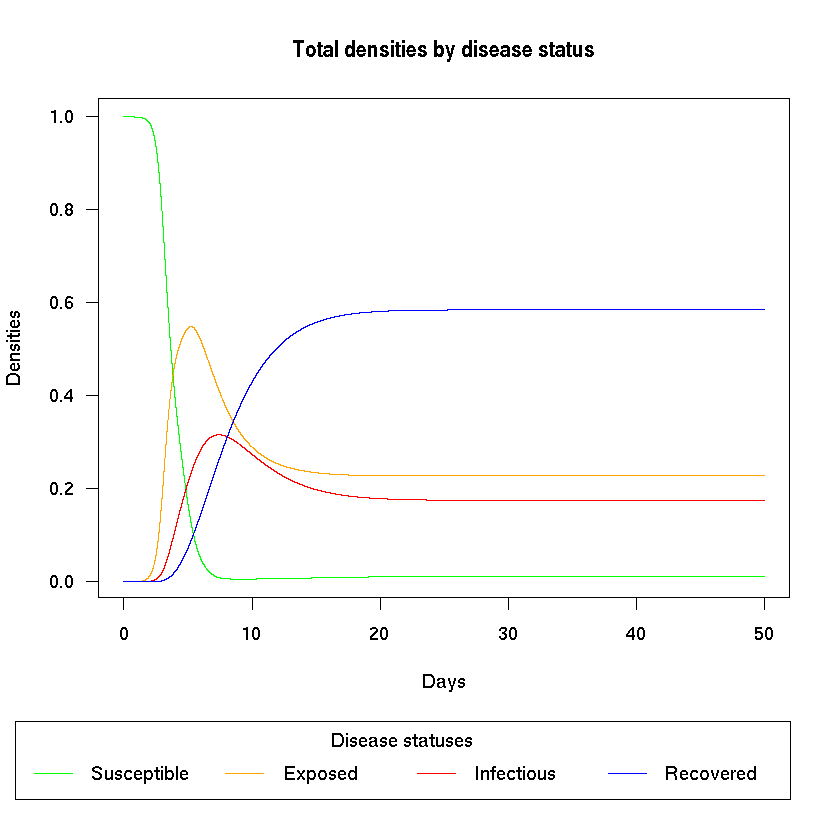

In [6]:
# plot total densities by disease status --------------------------------------#
plot.pretty(out, nr_patches, "total")

We can also plot the disease dynamics of some of the patches. Dynmics between patches may vary due to cross-coupling and migration rates.

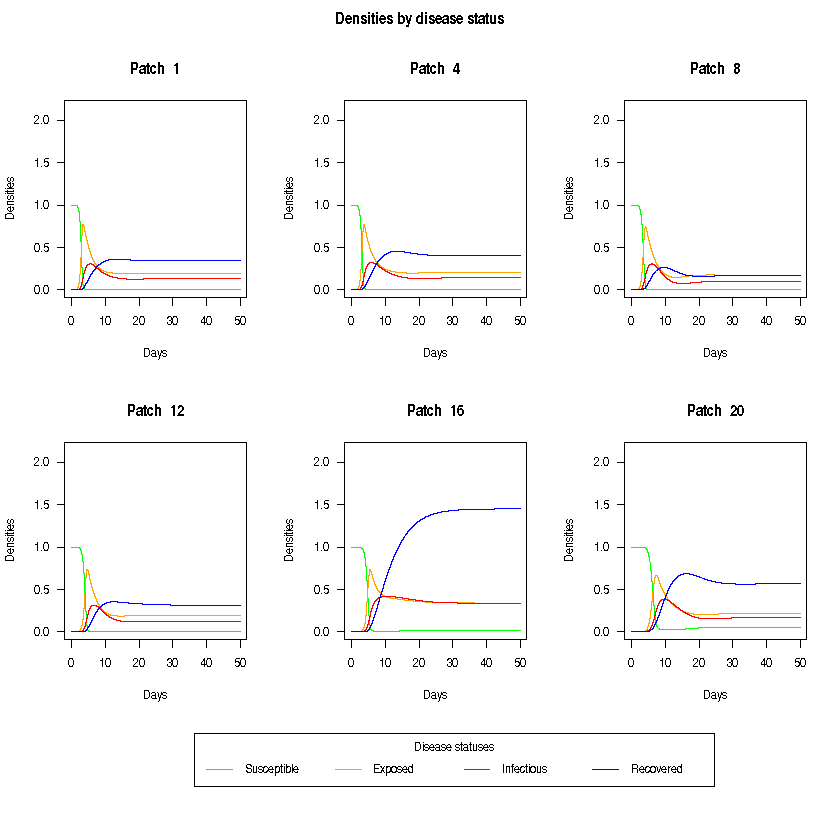

In [7]:
# plot densities of some patches by disease status ----------------------------#
plot.pretty(out, nr_patches, "panels")